# **Práctica 2**

La siguiente práctica está hecha sobre un Notebook de Kaggle, llamado *Formula 1 Pit Stops Analysis*, y su dataset proviene de *Formula 1 World Championship (1950 - 2024)*, también disponible en Kaggle.

el objetivo es aplicar al menos tres de los siguientes procesamientos en el dataset:
- Limpieza de datos
- Aumento de datos
- Extracción de características
- Reducción de dimensionalidad
- Selección de características

Posteriormente se debe hacer un análisis exploratorio en el dataset resultante.

## Limpieza de datos

El dataset fuente es muy extenso, pero la ventaja es que los datos están separados en varios documentos *.csv*, con lo cual la limpieza se va a reducir en gran parte en seleccionar los documentos con información interesante, buscar las columnas relevantes e ignorar aquellas que muestran información redundante o irrelevante. 

Dicho lo anterior, importamos las librerías con las que vamos a trabajar:

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import time

Importamos también los datos con los que vamos a trabajar, los cuales se encuentran en una carpeta local:

In [2]:
fpath = 'C:/Users/Black/Documents/Jupyter/Práctica 1/Dataset/'

races = pd.read_csv(f'{fpath}races.csv', index_col=0, na_values=r'\N')
constructors = pd.read_csv(f'{fpath}constructors.csv', index_col=0, na_values=r'\N')
drivers = pd.read_csv(f'{fpath}drivers.csv', index_col=0, na_values=r'\N')
pitStops = pd.read_csv(f'{fpath}pit_stops.csv', na_values=r'\N')
results = pd.read_csv(f'{fpath}results.csv', index_col=0, na_values=r'\N')
qualy = pd.read_csv(f'{fpath}qualifying.csv', index_col=0, na_values=r'\N')

Una vez importados los *.csv* que nos interesan en *dataframes*, analizamos las variables en cada conjunto de datos para seleccionar las más convenientes: 

In [3]:
races.columns.values

array(['year', 'round', 'circuitId', 'name', 'date', 'time', 'url',
       'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date',
       'fp3_time', 'quali_date', 'quali_time', 'sprint_date',
       'sprint_time'], dtype=object)

In [4]:
constructors.columns.values

array(['constructorRef', 'name', 'nationality', 'url'], dtype=object)

In [5]:
drivers.columns.values

array(['driverRef', 'number', 'code', 'forename', 'surname', 'dob',
       'nationality', 'url'], dtype=object)

In [6]:
pitStops.columns.values

array(['raceId', 'driverId', 'stop', 'lap', 'time', 'duration',
       'milliseconds'], dtype=object)

In [7]:
results.columns.values

array(['raceId', 'driverId', 'constructorId', 'number', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps',
       'time', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId'], dtype=object)

In [8]:
qualy.columns.values

array(['raceId', 'driverId', 'constructorId', 'number', 'position', 'q1',
       'q2', 'q3'], dtype=object)

Buscaremos hacer un *dataframe* con todos los datos que vamos a analizar. Este *dataframe* debe contener:
- Nombre del circuito
- Año en el que corrió
- Nombre del piloto
- Equipo al que pertenece
- Posición de arranque (clasificación)
- Tiempo promedio en pits
- Posición de su vuelta más rápida
- Booleano que indique el ganador de la carrera

Para ello, ordenamos todos los *dataframes* importados y transformamos algunas columnas:

In [9]:

races = races.rename(columns={'name':'raceName'}) #Renombrar columnas
races['raceName'] = races['raceName'] + ' ' + races['year'].astype(str) #Crear columna con el nombre del piloto
races = races[['raceName', 'circuitId', 'year']] #Delimitar dataframe


constructors = constructors.rename(columns={'name':'constructorName'}) #Renombrar columnas
constructors = constructors[['constructorName']] #Delimitar dataframe

drivers = drivers.rename(columns={'code':'driverCode'}) #Renombrar columnas
drivers['driverName'] = drivers['forename'] + ' ' + drivers['surname']
drivers = drivers[['driverName', 'driverCode']] #Delimitar dataframe

pitStops['pitTime'] = pitStops['milliseconds'] / 1000
pitStops = pitStops[['raceId', 'driverId', 'pitTime']] #Delimitar dataframe

prom_pitStops = pitStops.groupby(['raceId', 'driverId'])['pitTime'].mean() 
pitStops = pitStops.set_index(['raceId', 'driverId'])
pitStops['pitTime'] = prom_pitStops
pitStops = pitStops.reset_index().drop_duplicates()

results = results.rename(columns = {'positionOrder':'winnerLabel', 'rank':'fastestLapRank'}) #Renombrar columnas
results = results[['raceId', 'driverId', 'constructorId', 'fastestLapRank', 'winnerLabel']] #Delimitar dataframe
results['winnerLabel'] = (results['winnerLabel'] == 1).astype(int) #Booleano para indicar el ganador de la carrera

qualy = qualy.rename(columns = {'position':'qualyPosition'}) #Renombrar columnas
qualy = qualy[['raceId','driverId','qualyPosition']] #Delimitar dataframe

Ahora unimos los *dataframes* hasta obtener uno que contenga toda la información que buscamos analizar, el cual se llamará *formulaWinner*:

In [10]:

formulaWinner = pd.merge(results, races, left_on = 'raceId', right_index = True, how = 'left')
formulaWinner = pd.merge(formulaWinner, constructors, left_on = 'constructorId', right_index = True, how = 'left')
formulaWinner = pd.merge(formulaWinner, drivers, left_on = 'driverId', right_index = True, how = 'left')
formulaWinner = pd.merge(formulaWinner, pitStops, left_on = ['raceId', 'driverId'], right_on = ['raceId', 'driverId'])
formulaWinner = pd.merge(formulaWinner, qualy, left_on = ['raceId', 'driverId'], right_on = ['raceId', 'driverId'])


Por último quedaría reordenar las columnas y los registros para que quede más legible:

In [11]:
formulaWinner = formulaWinner.iloc[:,[0,6,5,7,1,10,9,2,8,12,11,3,4]]
formulaWinner = formulaWinner.sort_values(by=['raceId', 'driverId'])
formulaWinner[formulaWinner['driverId'] == 1].head()

,raceId,circuitId,raceName,year,driverId,driverCode,driverName,constructorId,constructorName,qualyPosition,pitTime,fastestLapRank,winnerLabel
1,841,1,Australian Grand Prix 2011,2011,1,HAM,Lewis Hamilton,1,McLaren,2,23.213000,8.0,0
28,842,2,Malaysian Grand Prix 2011,2011,1,HAM,Lewis Hamilton,1,McLaren,2,23.252750,5.0,0
43,843,17,Chinese Grand Prix 2011,2011,1,HAM,Lewis Hamilton,1,McLaren,3,20.659333,2.0,1
70,844,5,Turkish Grand Prix 2011,2011,1,HAM,Lewis Hamilton,1,McLaren,4,24.909250,4.0,0
90,845,4,Spanish Grand Prix 2011,2011,1,HAM,Lewis Hamilton,1,McLaren,3,20.364250,1.0,0


Y quitamos las columnas que generan redundancia, buscando que nuestro *dataframe* objetivo contenga solo registros con dimensiones numéricas:

In [12]:
formulaWinner2 = formulaWinner[['circuitId','year','driverId','constructorId','qualyPosition','pitTime','fastestLapRank','winnerLabel']]

## Reducción de Dimensionalidad

De forma preliminar, la naturaleza de los datos ya nos puede decir qué esperar: por decir algunos ejemplos, *Michael Schumacher* fue campeón del 2000 al 2004 con *Ferrari, *Sebastian Vettel* del 2010 al 2013 con *Red Bull*, *Lewis Hamilton* del 2014 al 2020 con *Mercedes* (excepto por el 2016), y *Max Verstappen* del 2021 al 2023 con *Red Bull*. Esto es que en la fórmula 1 suele haber "eras" en las que un piloto y una escudería gana carreras constantemente, por lo que el año, el equipo y el piloto pueden ser datos dependientes. Además, de forma más general, entre más alto clasifique un piloto, más probable es que gane la carrera. 

De lo anterior también podríamos intuir que tal vez existan algunas dimensiones en el *dataframe* que se puedan representar como una combinación lineal, por lo que PCA podría funcionar adecuadamente. Aún así, también probaremos con *t-SNE* y *UMAP* ya que mostraron ser mejores en clase al momento de agrupar los datos. Es así que crearemos nuestra matriz de muestras *X* y nuestro vector de etiquetas *y*:

In [13]:
X = formulaWinner2.iloc[:, 0:-1]
y = formulaWinner2.iloc[:, -1]

Y generamos nuestra *Reducción de Dimensionalidad* mediante PCA:

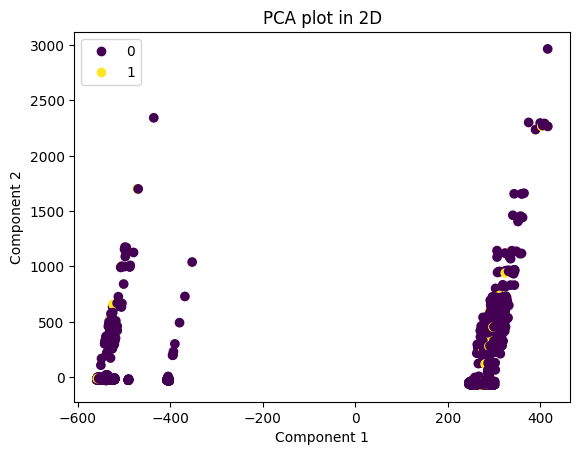

In [14]:
from sklearn.decomposition import PCA

X_PCA = PCA(n_components=2).fit_transform(X)

scatter = plt.scatter(X_PCA[:,0], X_PCA[:,1], c=y)
plt.title('PCA plot in 2D')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(*scatter.legend_elements())
plt.show()

**Observaciones**: Podemos ver que los registros de los pilotos que han ganado carreras no se están separando del resto de conjunto de registros, por lo que PCA en este caso no nos ayuda enu mucho.

Ahora, aplicamos la *Reducción de Dimensionalidad* mediante *t-SNE*:

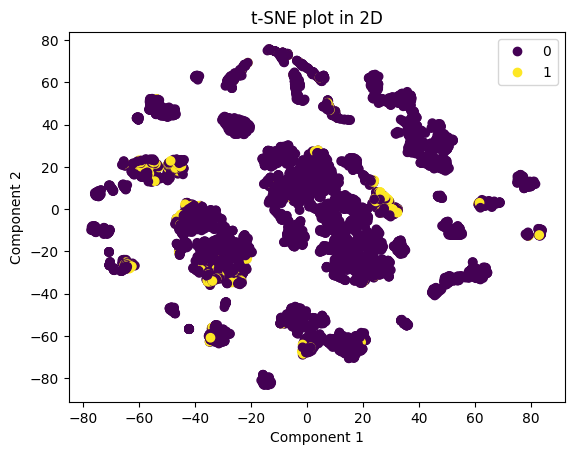

In [15]:
from sklearn.manifold import TSNE

X_TSNE = TSNE(n_components=2).fit_transform(X)

scatter = plt.scatter(X_TSNE[:,0], X_TSNE[:,1], c=y)
plt.title('t-SNE plot in 2D')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(*scatter.legend_elements())
plt.show()

**Observaciones**: Aquí son más notorias las regiones en donde están nuestros registros objetivo, sin embargo, sigue sin haber una separación bien definida del resto de los registros.

Queda entonces probar con *UMAP*, a lo cual se tiene:

C:\Users\Black\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


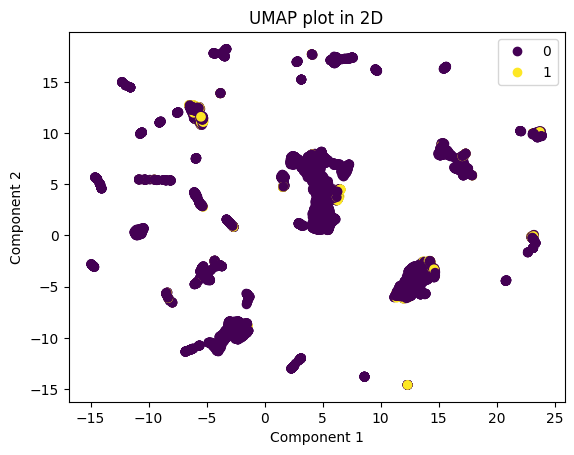

In [16]:
from umap import UMAP

X_UMAP = UMAP(n_components=2).fit_transform(X)

scatter = plt.scatter(X_UMAP[:,0], X_UMAP[:,1], c=y)
plt.title('UMAP plot in 2D')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(*scatter.legend_elements())
plt.show()

**Observaciones**: Realmente el método que mejor los separó fue *t-SNE*, pero no fue lo suficientemente bueno. 

## Selección de Características

Otra cosa que podemos intentar es hacer una selección de características, reducir algunas dimensiones de la matriz *X* manualmente y volver a aplicar la *Reducción de Dimensionalidad*, pero ahora aplicado a aquellas dimensiones que son más relevantes. Para esto podemos iniciar analizando el conjunto de muestras a través de un *pairplot*:

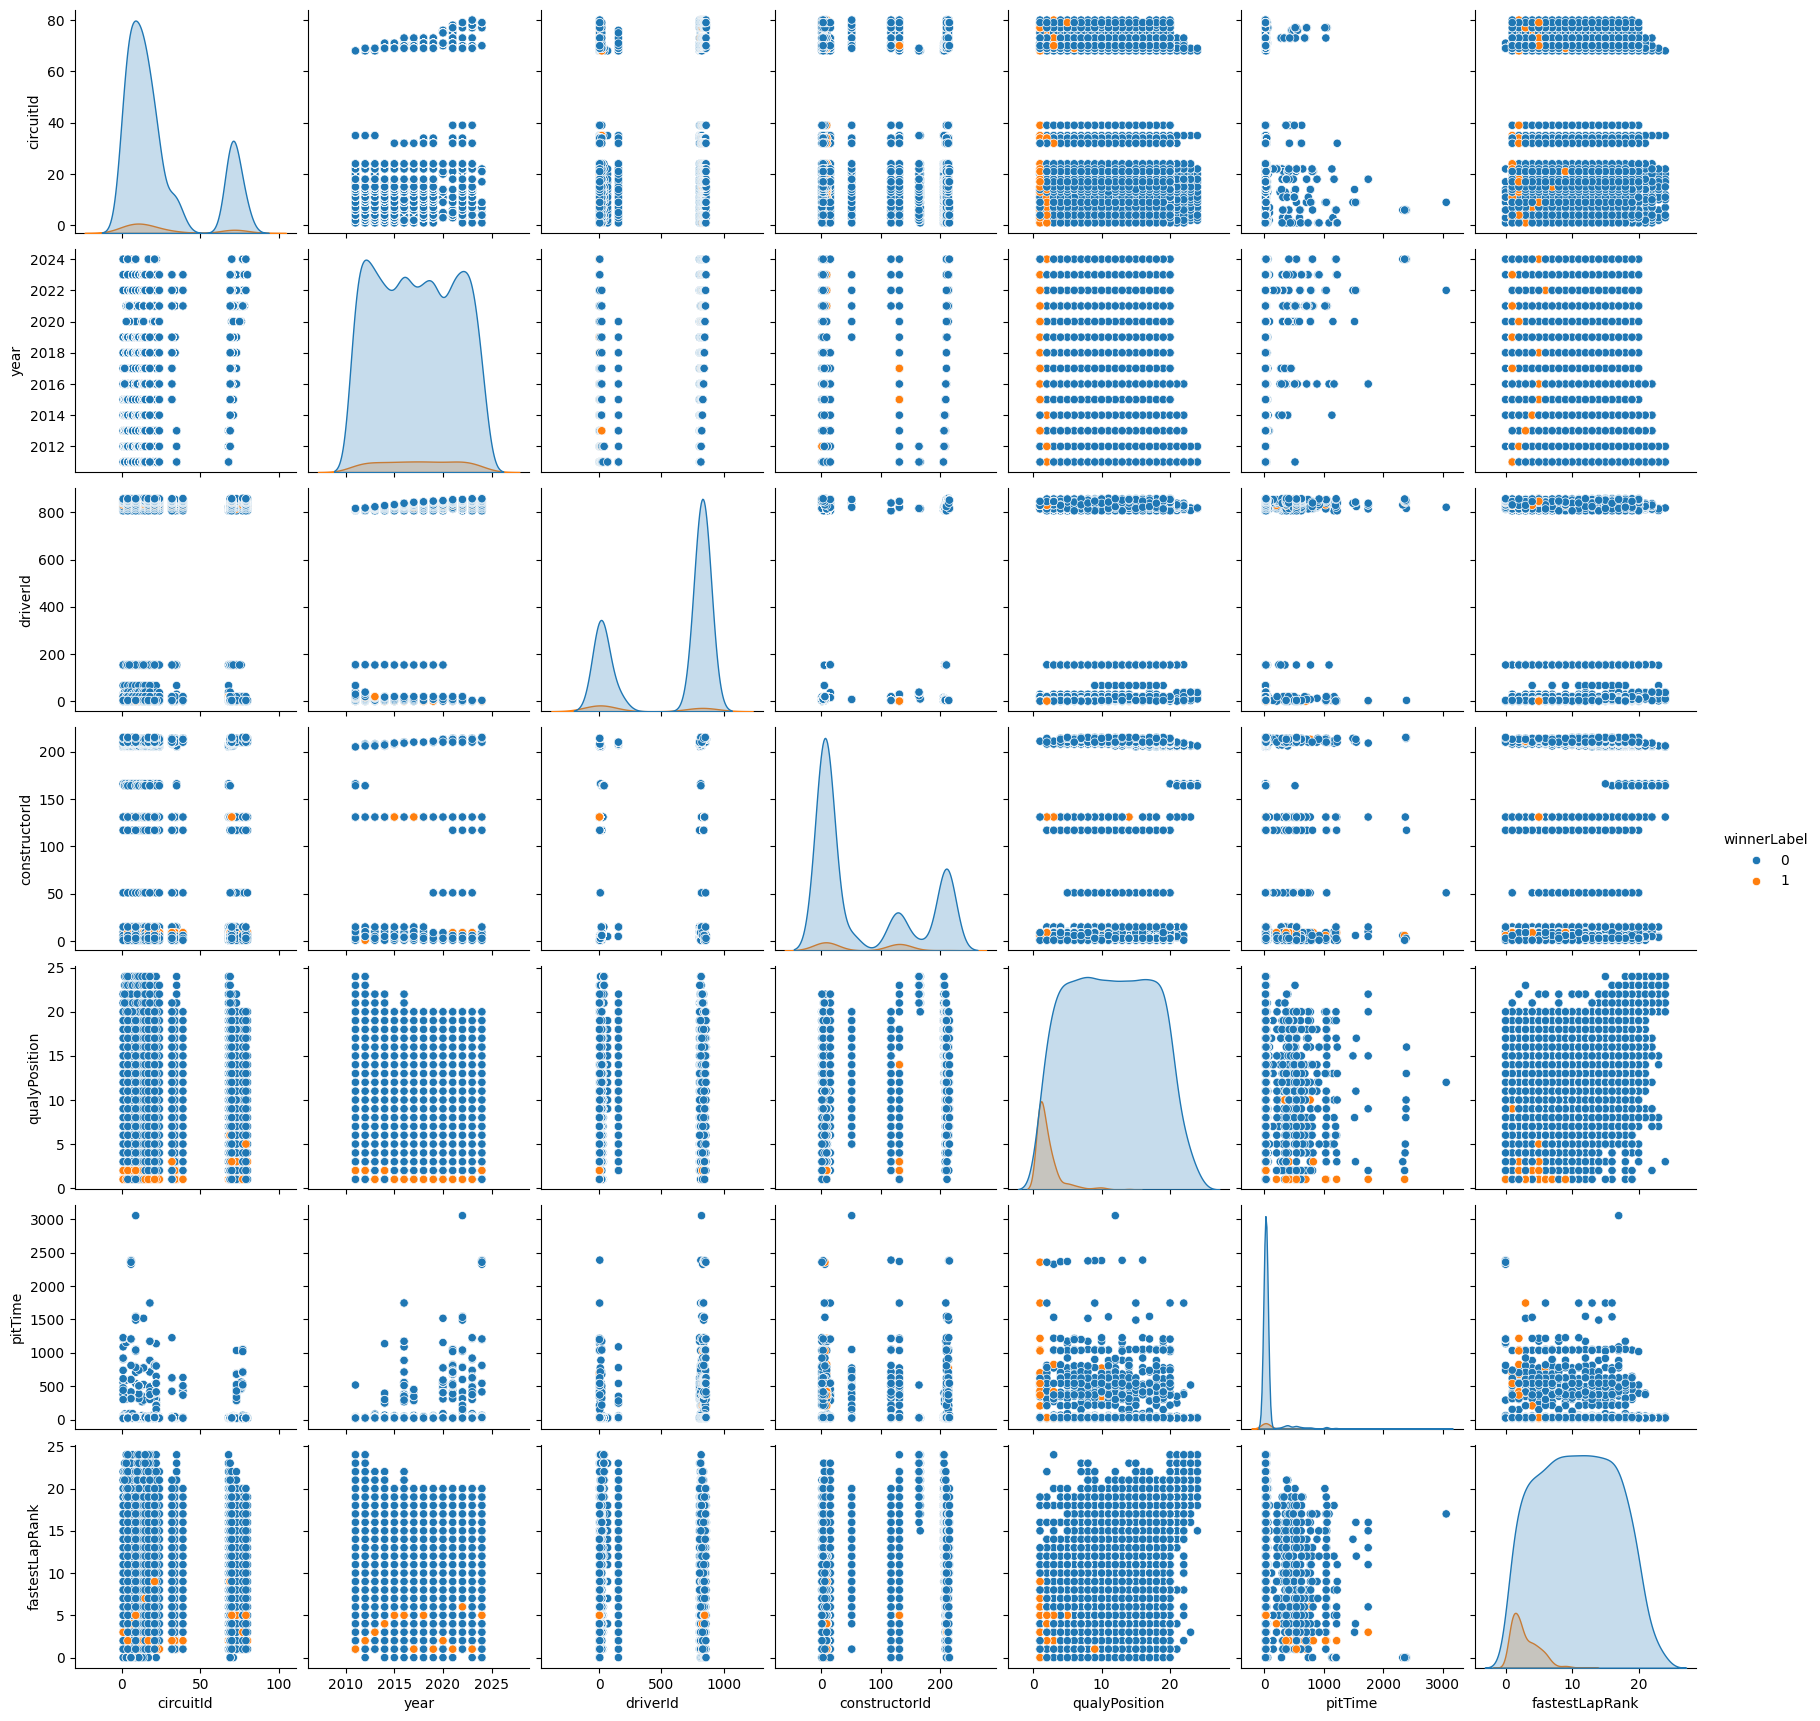

In [17]:
sns.pairplot(formulaWinner2, hue = 'winnerLabel')

**Observaciones**: En las gráficas anteriores podemos observar que la *qualyPosition* separa bien los valores que buscamos, por lo que es probable que las carreras ganadas muestren una alta dependencia a este valor. De cualquier forma, analizaremos la dependencia de las dimensiones con *InfoGain*:

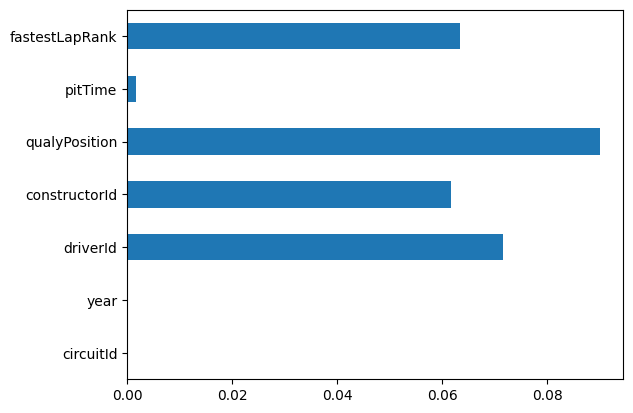

Execution time: 0.20 seconds


In [18]:
from sklearn.feature_selection import mutual_info_classif

# start time
start_time_forward = time.time()

### Applying feature selection method
X_new = mutual_info_classif(X, y)

# end time
end_time_forward = time.time()
time_forward = end_time_forward - start_time_forward

# plot feature selection
feat_imp = pd.Series(X_new, formulaWinner2.columns[0:len(formulaWinner2.columns)-1])
feat_imp.plot(kind='barh')
plt.show()

# show elapsed time of this method
print(f"Execution time: {time_forward:.2f} seconds")

**Observaciones**: Efectivamente se muestra una mayor dependencia de *qualyPosition*, seguido por *constructorId*, *driverId* y *fastestLapRank*, por lo que construiremos una segunda matriz de muestras con esas cuatro dimensiones:

In [19]:
X2 = formulaWinner2[['qualyPosition', 'constructorId', 'driverId', 'fastestLapRank']]

Y nuevamente intentaremos hacer una *Reducción de Dimensionalidad* con *PCA*, *t-SNE* y *UMAP*:

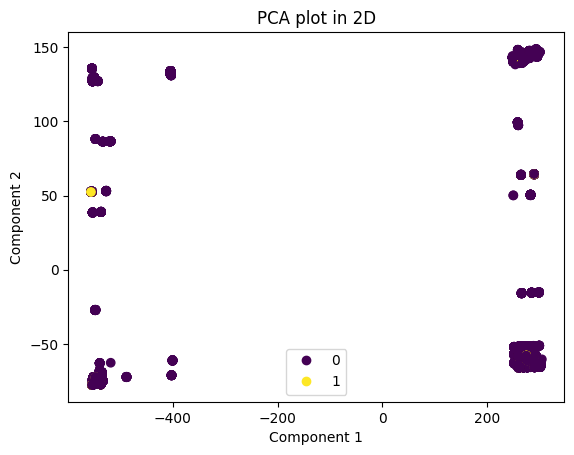

In [20]:
X2_PCA = PCA(n_components=2).fit_transform(X2)

scatter = plt.scatter(X2_PCA[:,0], X2_PCA[:,1], c=y)
plt.title('PCA plot in 2D')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(*scatter.legend_elements())
plt.show()

**Observaciones**: Para *PCA* se sigue sin tener una buena separación de los datos, aunque los registros de carreras ganadas aparentan concentrarse en solo dos regiones.

Para *t-SNE* se tiene lo siguiente:

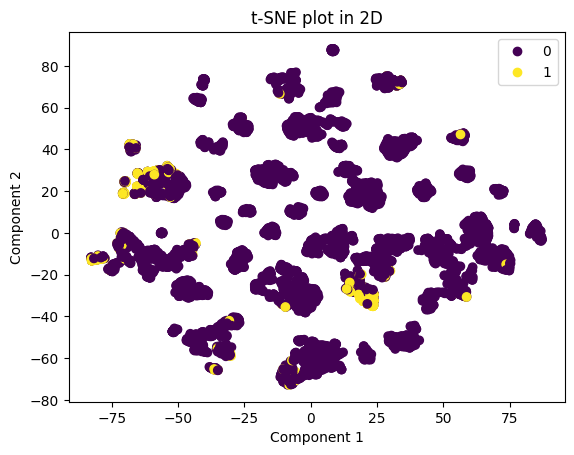

In [21]:
X2_TSNE = TSNE(n_components=2).fit_transform(X2)

scatter = plt.scatter(X2_TSNE[:,0], X2_TSNE[:,1], c=y)
plt.title('t-SNE plot in 2D')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(*scatter.legend_elements())
plt.show()

**Observaciones**: Aunque pareciera haber separado mejor los registros a cuando se usó la matriz de muestras *X*, la realidad es que el resultado es prácticamente el mismo.

Por último, tenemos a *UMAP*:

C:\Users\Black\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


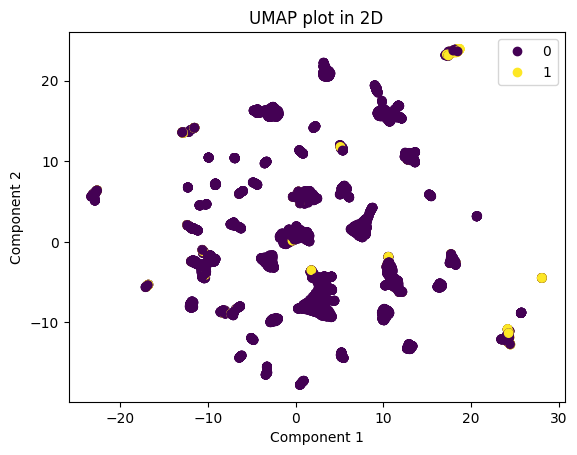

In [22]:

X2_UMAP = UMAP(n_components=2).fit_transform(X2)

scatter = plt.scatter(X2_UMAP[:,0], X2_UMAP[:,1], c=y)
plt.title('UMAP plot in 2D')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(*scatter.legend_elements())
plt.show()

**Observaciones**: La selección de características tampoco generó una mejoría aquí.

## Conclusiones

Intuituvamente uno podría pensar que al hacer una *Reducción de Dimensionalidad* después de una *Selección de Características*, se debería mostrar una mejoría en la clasificación de registros, sin embargo, no fue así para este caso.

El conjunto de datos contiene alrededor de 10,000 muestras, por lo que podría intentarse hacer un *Aumento de datos*, sin embargo, por la naturaleza de los datos no parece lo más conveniente. Por otra parte, no hay más registros de los que nos podamos apoyar, pero si hay muchas más dimensiones. 

Una propuesta es el repetir el ejercicio pero sin una *Limpieza de datos* tan exhaustiva, permitiendo que tengamos muchas más dimensiones en nuestro *dataframe* y así analizarlas mediante una *Selección de Características*. Así tendríamos un mayor margen para encontrar *Insights* que probablemente no se ven a simple vista en el *dataset*.